# Implementation of the Value Iteration Algorithm on the Frozen Lake

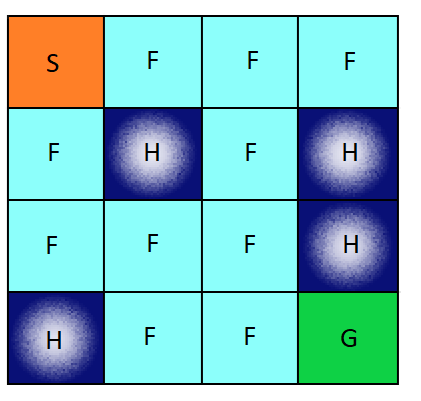

Imagine, there is a frozen lake from your home to office, you should walk on the frozen lake to reach your office. But oops! there will be a hole in the frozen lake in between, so you have to be careful while walking in the frozen lake to avoid getting trapped at holes. Look at the below figure where,

S is the starting position (Home)
F is the Frozen lake where you can walk
H is the Hole which you have to be so careful about
G is the Goal (office)
title

Okay, now let us use our agent instead of you to find the correct way to reach the office. The agent goal is to find the optimal path to reach from S to G without getting trapped at H. How an agent can achieve this? We give +1 point as a reward to the agent if it correctly walks on the frozen lake and 0 points if it falls into the hole. So that agent could determine which is the right action. An agent will now try to find the optimal policy. Optimal policy implies taking the correct path which maximizes the agent reward. If the agent is maximizing the reward, apparently agent is learning to skip the hole and reach the destination.

In [5]:
import gym
import numpy as np

## <a id="everything"></a>Summary of the RL theory learned so far

<div class="alert-success">
<ul>
<li> A **Markov Decision Process** (MDP) is a 4-tuple $\langle S,A,p,r \rangle$. $S$ is the state space, $A$ is the action space, $p(s'|s,a)$ the transition model and $r(s,a)$ the reward model.
<li> A **policy** is a mapping $\pi:S\rightarrow A$ that specifies what to do in a given state.
<li> **Value function of a policy**: $V^\pi(s)=\mathbb{E}\left( \sum\limits_{t = 0}^T \gamma^t r_t \bigg| s_0 = s, \pi \right)$
<li> **State-action value function of a policy**: $Q^\pi(s,a) = \mathbb{E}\left( \sum\limits_{t = 0}^T \gamma^t r_t \bigg| s_0 = s, a_0=a, \pi \right)$
<li> **Optimal policy $\pi^*$** dominates every other possible policy in every state: $\forall s, \ V^*(s) = V^{\pi^*}(s) \geq V^\pi(s)$
</ul>

<div class="alert-success">
<ul>
<li> **Expectation equation**: $V^\pi$ is the only solution to $V\left(s\right) =  r\left(s,\pi\left(s\right)\right) + \gamma \sum\limits_{s'\in S} p\left(s'|s,\pi\left(s\right)\right) V\left(s'\right)$<br>
Similarly, $Q^\pi$ is the only solution to $Q\left(s,a\right) = r\left(s,a\right) + \gamma \sum\limits_{s'\in S} p\left(s'|s,a\right) Q\left(s', \pi\left(s'\right)\right)$
<li> **Optimality equation**: $V^*$ is the only solution to $V(s)  = \max\limits_{a\in A} \left\{ r(s,a) + \gamma \sum\limits_{s'\in S} p(s'|s,a) V(s') \right\}$<br>
Similarly, $Q^*$ is the only solution to $Q(s,a) = r(s,a) + \gamma \sum\limits_{s'\in S}p(s'|s,a) \max\limits_{a'\in A} Q(s',a')$
</ul>
</div>

<div class="alert-success">
<li> **Value Iteration**: finding $V^*$ (or $Q^*$) by repeatedly applying the Bellman Optimal Equation to any initial function
<li> **Policy Iteration**: finding $\pi^*$ from any initial policy by building the sequence $\pi_{n+1}(s) = \arg\max_{a\in A} Q^{\pi_n}(s,a)$ that converges towards $\pi^*$; $Q^{\pi_n}(s,a)$ is computing using the Bellman Expectation Equation
</div>

## <a id="gym"></a>Some Gym notions

Gym environments all are encapsulated so that they have the same API. This can be described by calling `help(gym.Env)` Namely, they all have 5 methods and 3 attributes.

**Methods**:
- `step` --- Runs one timestep of the environment's dynamics. When end of episode is reached, you are responsible for calling `reset()`  to reset this environment's state. Accepts an action and returns a tuple (observation, reward, done, info).
- `reset` --- Resets the state of the environment and returns an initial observation.
- `render` --- Renders the environment. The set of supported modes varies per environment. See `help(gym.Env.render)` for details and arguments.
- `close` --- Cleans everything up, shuts the light and closes the door.
- `seed` --- Sets the seed for this env's random number generator(s).

**Attributes**:
- `action_space` --- The Space(*) object corresponding to valid actions.
- `observation_space` --- The Space(*) object corresponding to valid observations.
- `reward_range` --- A tuple corresponding to the min and max possible rewards.

(*) `Space` is a class (`help(gym.Space)`) that defines a set, be it continuous or discrete, with some useful methods. It is used specifically as the type of the action and observation spaces.

Beyond those common API methods, some class-specific methods or attributes can be accessed by using the `unwrapped` attribute of each environment (if present) as in the example above.

**General references on OpenAI Gym:**
- [The short description paper](https://arxiv.org/pdf/1606.01540.pdf)
- [The github page](https://github.com/openai/gym/blob/master/gym/envs/toy_text/discrete.py) (the most useful resource!)
- [The general introduction to Gym](https://gym.openai.com/docs/)
- [The deprecated list of environments](https://gym.openai.com/envs/) (refer to the github page for the latest version).

## Looking at the environment

In [6]:
env=gym.make('FrozenLake-v0')

[2019-08-30 16:15:17,774] Making new env: FrozenLake-v0


In [7]:
env.render()

SFFF
FHFH
FFFH
HFFG



|  S : starting point, safe  
|  F : frozen surface, safe  
|  H : hole, fall to your doom  
|  G : goal, where your office is located  
|  
|  The episode ends when you reach the goal or fall in a hole.  
|  You receive a reward of 1 if you reach the goal, and zero otherwise.

### State Space, Action Space, Model of the environment

In [8]:
print(env.observation_space.n)

16


In [9]:
print(env.action_space.n)

4


**action space**:  
left=0, down=1, right=2, up=3

In [10]:
#model of the environment - example for first state
env.P[0]

{0: [(0.3333333333333333, 0, 0.0, False),
  (0.3333333333333333, 0, 0.0, False),
  (0.3333333333333333, 4, 0.0, False)],
 1: [(0.3333333333333333, 0, 0.0, False),
  (0.3333333333333333, 4, 0.0, False),
  (0.3333333333333333, 1, 0.0, False)],
 2: [(0.3333333333333333, 4, 0.0, False),
  (0.3333333333333333, 1, 0.0, False),
  (0.3333333333333333, 0, 0.0, False)],
 3: [(0.3333333333333333, 1, 0.0, False),
  (0.3333333333333333, 0, 0.0, False),
  (0.3333333333333333, 0, 0.0, False)]}

In [11]:
env.P[0][0] #first state, action moving left

[(0.3333333333333333, 0, 0.0, False),
 (0.3333333333333333, 0, 0.0, False),
 (0.3333333333333333, 4, 0.0, False)]

**env.P(s) gives you for each possible action a:**
* all the possible next states s'
* the probability model p(s'|s,a)
* and the reward r(s'|s,a)
* A boolean if s' is a terminal state or no

### Parameters of the Value Iteration Algorithm
* **The discount rate $\gamma$**: you can start with a value $\gamma=0.8$ and varying it to see its impact on the optimal policy 
* **The convergence threshold**: a threshold of $10^-5$ is a good target
* **The number of iterations**: The maximum number of updates for the value function: should be large enough to allow convergence. You can start with 100,000 iterations.

In [12]:
gamma=0.9
num_iterations=100000
thresold=10^-5

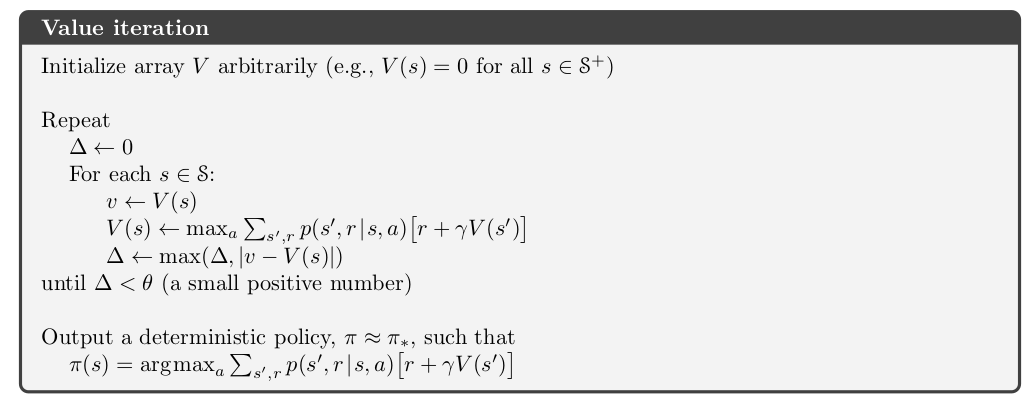

## Steps to implement the Value Iteration algorithm

### 1. Computation of the optimal Value Function V*

* Initialization of the Value Function for each state V(s) (numpy table with zero initial values)

* First Loop over all the iterations 

* For each state of the state space (loop over states)
* And for each action of the action space (loop over actions)
* Store the transition (transition proba $p(s'|s,a)$, next state s', immediate reward $r(s'|s,a)$) for each possible next state
* And compute the quantity: $Q(s,a)=\sum\limits_{s'\in S} p(s'|s,a)*(r(s'|s,a)+\gamma*V(s'))$
* Update V(s): $V_{new}(s) \leftarrow \max\limits_{a\in A} Q(s,a)$
* Check if V has reached convergence: ($ \sum\limits_{s \in S} |V(s)-V_{new}(s)| < threshold$): 
    if so break the loop over the iterations
* Return the latest value of the Value Function

### 2. Derive $\pi^*$ from $V^*$
#### Create a function extract_policy taking as parameter $V^*$
* For all the states in the state space
* Loop over all the possible actions and store the transition (transition proba $p(s'|s,a)$, next state s', immediate reward $r(s'|s,a)$)
* Compute $Q(s,a)=\sum\limits_{s'\in S} p(s'|s,a)*(r(s'|s,a)+\gamma*V^*(s'))$ for each action a
* Compute $\pi^*=\arg\max\limits_{a \in A} Q(s,a)$

In [13]:
def value_iteration(env, gamma=0.9, num_iterations=100000, thresold=1e-5):
    # initialize value tables with zeros
    value_table=np.zeros(env.observation_space.n)
    
    # setting number of iterations and thresold 
    #thresold=1e-20
    for i in range(num_iterations):
    
        # copying the value table to the updated value_table
        old_value_table=np.copy(value_table)
    
        for state in range(env.observation_space.n):
            Q_value=[]
            for action in range(env.action_space.n):
                next_states_rewards=[] # next state rewards store the Q_Value for each action
                for next_s in env.P[state][action]:
                    # env.P gets the model of the env: (p(s'|s,a),s',r(s'|s,a))
                    trans_prob, next_state, reward_prob, _=next_s
                    next_states_rewards.append(trans_prob*(reward_prob+gamma*old_value_table[next_state]))
                Q_value.append(np.sum(next_states_rewards))
                # Q_value <-sum over s' (p(s'|s,a)*(r(s'|s,a)+gamma*V(s')))
            
            value_table[state]=max(Q_value)
            # Q_value is a list of [q(state, a') for all a' in action space]
            # V_updated (state) <- max over actions (Q(state, action))
        
        if(np.sum(np.fabs(old_value_table-value_table))<=thresold):
            print('Value Iteration converging at iteration:{}'.format(i+1))
            break
    value_table=np.resize(value_table, (4,4))
    
    return value_table

In [14]:
value_iteration(env)

Value Iteration converging at iteration:75


array([[0.06888152, 0.06140662, 0.07440396, 0.05580094],
       [0.09184601, 0.        , 0.11220509, 0.        ],
       [0.14542945, 0.2474923 , 0.29961431, 0.        ],
       [0.        , 0.37993254, 0.63901839, 0.        ]])

### Plotting of the value table evolution

In [15]:
def plot(num_iterations):
    return value_iteration(env, num_iterations=num_iterations)

In [16]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [17]:
interact(plot, num_iterations=160)

<function __main__.plot>

### computing the optimal policy from the optimal value function 

In [18]:
def extract_policy(env, value_table, gamma=0.9):
    # initializing the policy table
    policy=np.zeros(env.observation_space.n)
    
    for state in range(env.observation_space.n):
        
        # initializing the Q_table for each state
        Q_table=np.zeros(env.action_space.n)
        
        # compute Q Value for each actions of the state
        #Q_value(state,action) <-sum over s' (p(s'|s,a)*(r(s'|s,a)+gamma*V(s')))
        for action in range(env.action_space.n):
            for next_s in env.P[state][action]:
                trans_prob, next_state, reward_prob, _=next_s
                # adding the next_state_rewards for the succesor state next_state to the Q_value
                Q_table[action]+=(trans_prob*(reward_prob+gamma*value_table[next_state]))
             
        #select the action that has the maximum Q-value for finding the optimal policy
        policy[state]=np.argmax(Q_table)
        #pi(state)<-argmax over actions (Q_table(state, action))
            
    return policy

In [19]:
value_table=value_iteration(env)
optimal_policy=extract_policy(env, value_table.reshape(-1))
print(optimal_policy.reshape(4,4))

Value Iteration converging at iteration:75
[[0. 3. 0. 3.]
 [0. 0. 0. 0.]
 [3. 1. 0. 0.]
 [0. 2. 1. 0.]]


In [20]:
policy_string = optimal_policy.reshape(4,4).astype(str)
action_map = {
    0: "l",
    1: "d",
    2: "r",
    3: "u"
}

for k, v in action_map.items():
    policy_string[optimal_policy.reshape(4,4) == k] = v
print(policy_string)

[['l' 'u' 'l' 'u']
 ['l' 'l' 'l' 'l']
 ['u' 'd' 'l' 'l']
 ['l' 'r' 'd' 'l']]
